In [5]:
import networkx as nx
import numpy as np
from gurobipy import Model, GRB, LinExpr
import numpy as np

# DCNDP for weighted graph

In [6]:
# Def to get a graph in file format .edgelist or .gml, given a file-path
def get_graph(path: str):
    if path.endswith('.edgelist'):
        return nx.read_edgelist(path=path, nodetype=int)
    else:
        return nx.read_gml(path=path, label='id')

In [31]:
G = get_graph('data/Synthetic_networks/synthetic_graphs/er2(1).gml')

In [32]:
N = G.number_of_nodes()
C = int(0.05 * N)
#assign weights to edges based on edge betweenness
edge_btw=nx.edge_betweenness_centrality(G, normalized=True)

for e in G.edges():
    G.edges[e[0],e[1]]['weight'] = min(4,round(edge_btw[e]/0.1))

L=nx.diameter(G) #diameter of the graph

ind=0
#define distance connectivity function (eg f(d)=1/d)
f=[]
for l in range(L+1):
    f.append(1/float(l+1))

In [33]:
# global variable
cut_count = 0
bound_check = 0
node_count = 0
global bound_save

### Define the modified cut callback

In [34]:
# -----separates integer solution
def first_depth_k_bfs(graph, cost, connect, L, cut_limit, model):
    global cut_count
    roots = [n for (n, attr) in cost.items() if attr < 1 - 1e-5]
    input_graph = graph.subgraph(roots)
    for rt in roots:
        cut_count = 0
        length, path = nx.single_source_dijkstra(input_graph, rt,
                                                 cutoff=L, weight='weight')
        for v, distance in length.items():
            if rt != v:
                i = min([rt, v])
                j = max([rt, v])
                if connect[(i, j)] < f[distance - 1]:
                    model.cbLazy((f[distance - 1]
                                  * sum(model._x_delete[node] for node in path[v]))
                                 + model._u_connect[i, j] >= f[distance - 1])
                    cut_count += 1
                    if cut_count == cut_limit:
                        break

In [35]:
# -----separates fractional solution
def second_depth_k_bfs(graph, cost, connect, L, cut_limit, model):
    global cut_count
    roots = [n for (n, attr) in cost.items() if attr < 1 - 1e-5]
    # get a SubGraph view of the subgraph induced on nodes
    input_graph = graph.subgraph(roots)
    for rt in roots:
        cut_count = 0
        # Find shortest weighted paths and lengths from a source node.
        # Compute the shortest path length between source and all other reachable nodes for a weighted graph.
        length, path = nx.single_source_dijkstra(input_graph, rt, cutoff=L, weight='weight')
        for v, distance in length.items():
            if rt != v:
                i = min([rt, v])
                j = max([rt, v])
                if (f[distance - 1] * sum(cost[node] for node in path[v])) + connect[(i, j)] < f[distance - 1]:
                    model.cbLazy( (f[distance - 1] * sum(model._x_delete[node] for node in path[v]))
                                  + model._u_connect[i, j] >= f[distance - 1])
                    cut_count += 1
                    if cut_count == cut_limit:
                        break

In [36]:
def cut(model, where):
    global bound_save, bound_check, node_count
    cost = {}
    connect = {}

    # if integer solution
    if where == GRB.Callback.MIPSOL:
        bound_save = model.cbGet(GRB.callback.MIPSOL_OBJBND)
        node_count = model.cbGet(GRB.Callback.MIPSOL_NODCNT)
        for j in G.nodes():
            cost[j] = abs(model.cbGetSolution(model._x_delete[j]))
            for i in G.nodes():
                if i < j:
                    connect[(i, j)] = abs(model.cbGetSolution(model._u_connect[i, j]))
        first_depth_k_bfs(G, cost, connect, L, GRB.INFINITY, model)

    # if fractional solution
    elif where == GRB.Callback.MIPNODE:
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.Status.OPTIMAL:
            current_bound = model.cbGet(GRB.callback.MIPNODE_OBJBND)
            node_count = int(model.cbGet(GRB.callback.MIPNODE_NODCNT))
            if bound_save == current_bound:
                bound_check += 1
                if bound_check >= 5 or node_count > 0:
                    bound_check = 0
                else:
                    for j in G.nodes():
                        cost[j] = abs(model.cbGetNodeRel(model._x_delete[j]))
                        for i in G.nodes():
                            if i < j:
                                connect[(i, j)] = abs(model.cbGetNodeRel(model._u_connect[i, j]))
                    second_depth_k_bfs(G, cost, connect, L, 300, model)

            else:
                bound_save = current_bound
                for j in G.nodes():
                    cost[j] = abs(model.cbGetNodeRel(model._x_delete[j]))
                    for i in G.nodes():
                        if i < j:
                            connect[(i, j)] = abs(model.cbGetNodeRel(model._u_connect[i, j]))
                second_depth_k_bfs(G, cost, connect, L, 300, model)

## Gurobi Model Implementation

### Define the variables
$$
x_{i} = \begin{cases}
  1, \quad if \; node \, i \, is \, deleted \\
  0, \quad if \; otherwise \\
\end{cases}
\\
y_{i,j} = \begin{cases}
  1, \quad if \; (i,j) \, \, are \, connected \, by \,  a \, path \, \leq k \, in \, G^r\\
  0, \quad otherwise \\
\end{cases}
$$

### Model DCMDP 1
$$
Min. \quad \sum_{i,j \in V : i < j} y_{i,j}
\\
\\
\sum_{i \in V} x_{i} \leq B
\\
\\
\sum_{r \in V(P)} f(d) x_{r} + y_{i,j} \geq f(d), \quad \forall P \in P_{k}(i,j), \quad (i,j) \in V, \quad i<j
\\
\\
x_{i} \in {0,1}, \quad \forall v \in V
\\
\\
y_{i,j} \in {0,1}, \quad \forall (i,j) \in V, \quad i<j

$$

In [37]:
def minimize_dcnp(input_graph, L, C):
    model = Model('Minimize distance-based pairwise connectivity eg efficiency')

    # variables
    x_delete = {}
    u_connect = {}
    for j in input_graph.nodes():
        # The node degree is the number of edges adjacent to the node.
        if input_graph.degree[j] == 1:
            x_delete[j] = model.addVar(lb=0.0, ub=0.0, vtype=GRB.BINARY, name=f'x[{j}')
        else:
            x_delete[j] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.BINARY, name=f'x[{j}')
        for i in input_graph.nodes():
            if i < j:
                u_connect[i, j] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS,
                                               name=f'u[{i}, {j}]')

    # objective
    obj = LinExpr(0)
    for j in input_graph.nodes():
        for i in input_graph.nodes():
            if i < j:
                obj.add(u_connect[i, j])

    # constraint on number of critical nodes
    model.addConstr(sum((x_delete[j]) for j in input_graph.nodes()) <= C)

    # constraints on connectivity variables u
    # constraints on (i,j) in E
    for (i, j) in input_graph.edges():
        weight = input_graph.edges[i, j]['weight']
        if i < j:
            model.addConstr(u_connect[i, j] + f[weight] * (x_delete[i] + x_delete[j]) >= f[weight])
        else:  # that is j<i
            model.addConstr(u_connect[j, i] + f[weight] * (x_delete[j] + x_delete[i]) >= f[weight])

    model.update()
    model.setObjective(obj, GRB.MINIMIZE)
    model._x_delete = x_delete
    model._u_connect = u_connect
    model.setParam(GRB.param.Cuts, 0)
    model.setParam(GRB.param.PreCrush, 1)
    model.setParam('LazyConstraints', 1)
    model.setParam('TimeLimit', 3600)
    model.optimize(cut)
    run_time = model.Runtime
    x_delete_val = model.getAttr('x', x_delete)

    critical_nodes = [i for i in x_delete_val.keys() if x_delete_val[i] >= 1 - 1e-4]

    return critical_nodes, obj.getValue(), run_time, model

### Get the result and plot the graph

In [38]:
# find the critical nodes
critical_nodes, opt_obj, run_time, model = minimize_dcnp(G, L, C)
print(f'N nodes: {G.number_of_nodes()}')
print(f'N nodes: {G.number_of_edges()}')
print(f'Diameter: {nx.diameter(G)}')
print('percentage distance-based pairwise connectivity = {:.2f}%'.format(
    2 * 100 * opt_obj / (G.number_of_nodes() * (G.number_of_nodes() - 1))))
print(f'cos: {C}')
print(f'num vars: {model.getAttr(GRB.Attr.NumVars)}')
print("critical nodes are :", critical_nodes)
print("Running Time = {:.2f} seconds".format(run_time))
print('distance-based pairwise connectivity = {:.2f} nodes'.format(opt_obj))
print(model.getAttr(GRB.Attr.ObjBound))
print(f'Status {model.getAttr(GRB.Attr.Status)}')
print(f'Work: {model.getAttr(GRB.Attr.Work)}')

Set parameter Cuts to value 0
Set parameter PreCrush to value 1
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1033 rows, 20100 columns and 3296 nonzeros
Model fingerprint: 0xfc0ec6e5
Variable types: 19900 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve time: 0.00s
Presolved: 1033 rows, 20100 columns, 3296 nonzeros
Variable types: 19900 continuous, 200 integer (200 binary)

Root relaxation: objective 8.560000e+02, 1837 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3345.72500    0   24 

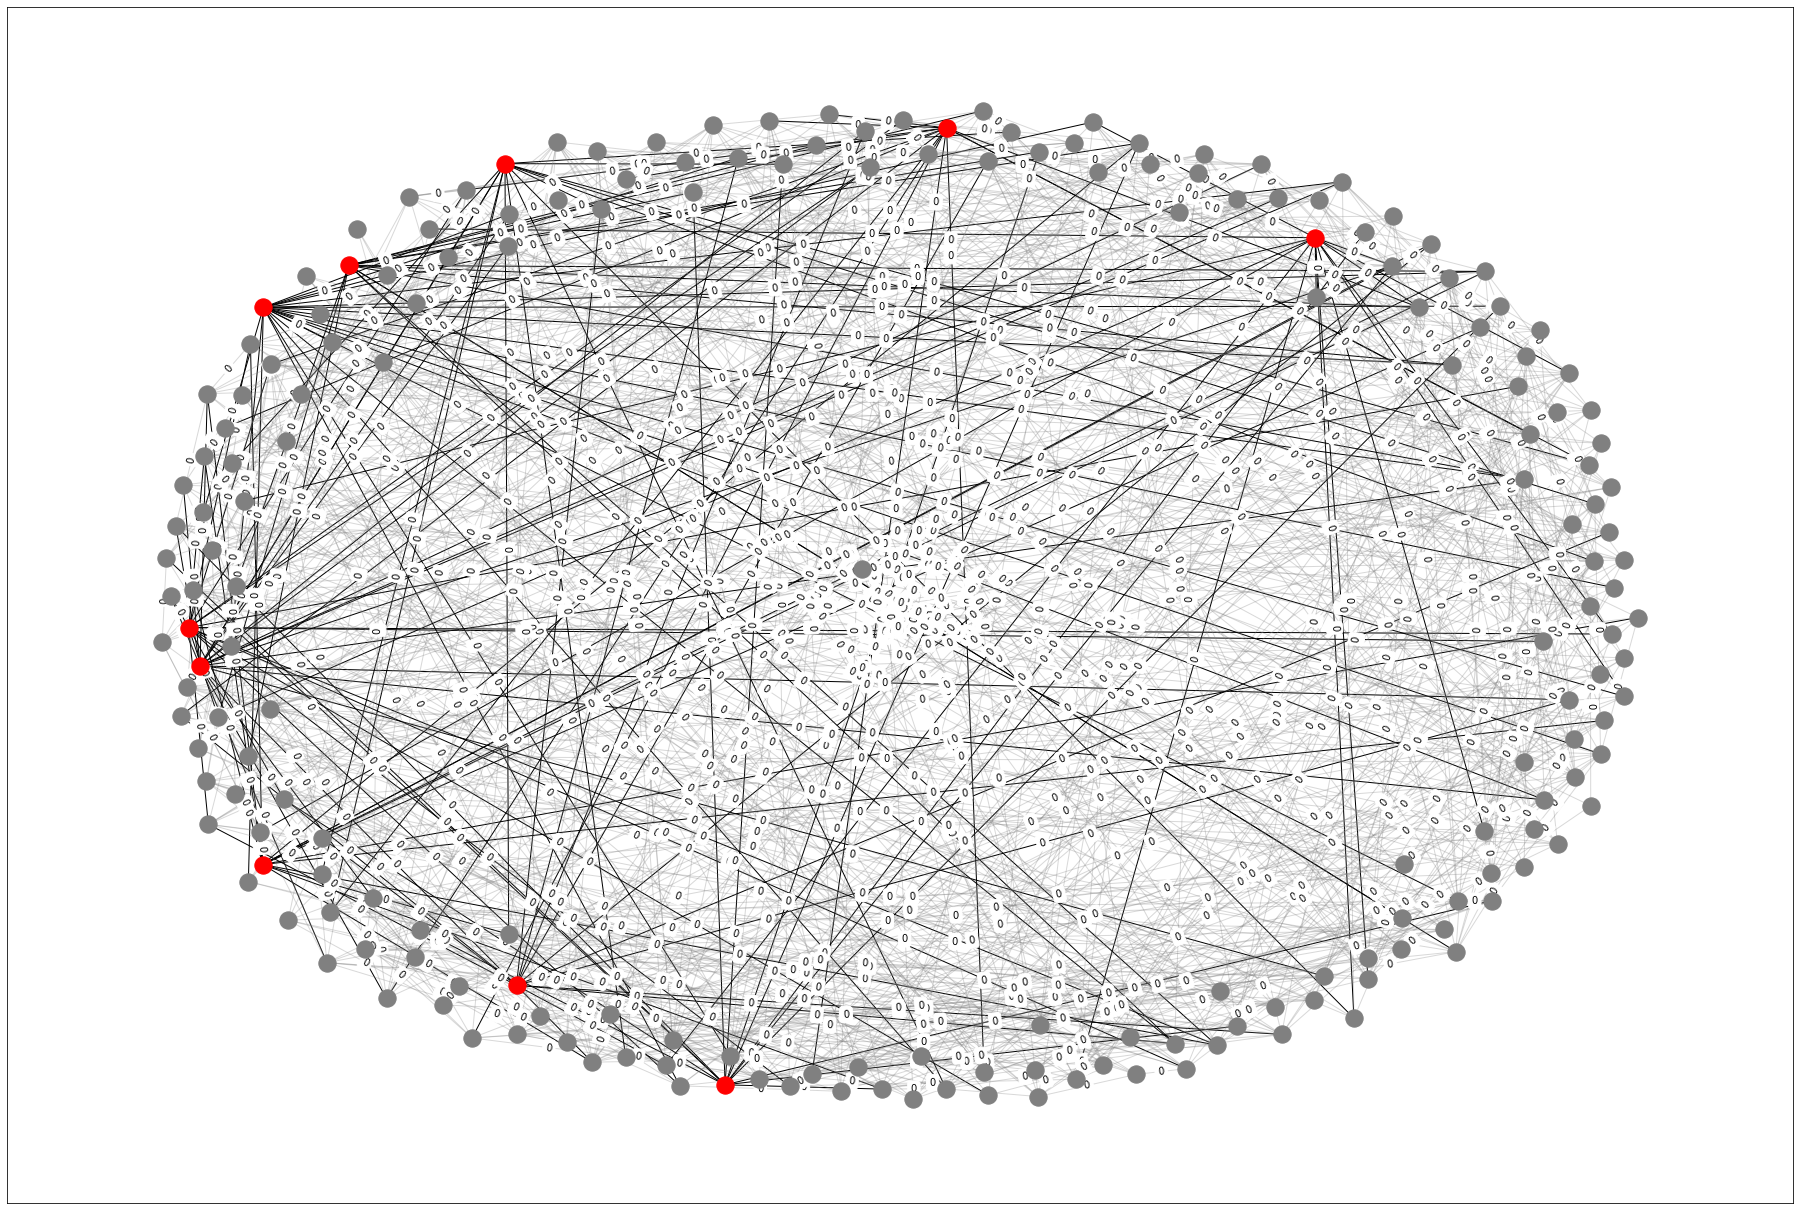

In [39]:
from matplotlib import pyplot as plt

# split edges and nodes for drawing
removed_edges = [(i, j) for (i, j) in G.edges() if (i in critical_nodes or j in critical_nodes)]
remaining_edges = [(i, j) for (i, j) in G.edges() if (i, j) not in removed_edges]
remaining_nodes = [i for i in G.nodes() if i not in critical_nodes]
pos = nx.spring_layout(G, seed=42)  # spring parameter k
plt.figure(figsize=[32, 22])
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_nodes(G, pos, nodelist=critical_nodes, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=remaining_nodes, node_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='k')
nx.draw_networkx_edges(G, pos, edgelist=remaining_edges, edge_color='gray', alpha=0.3)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

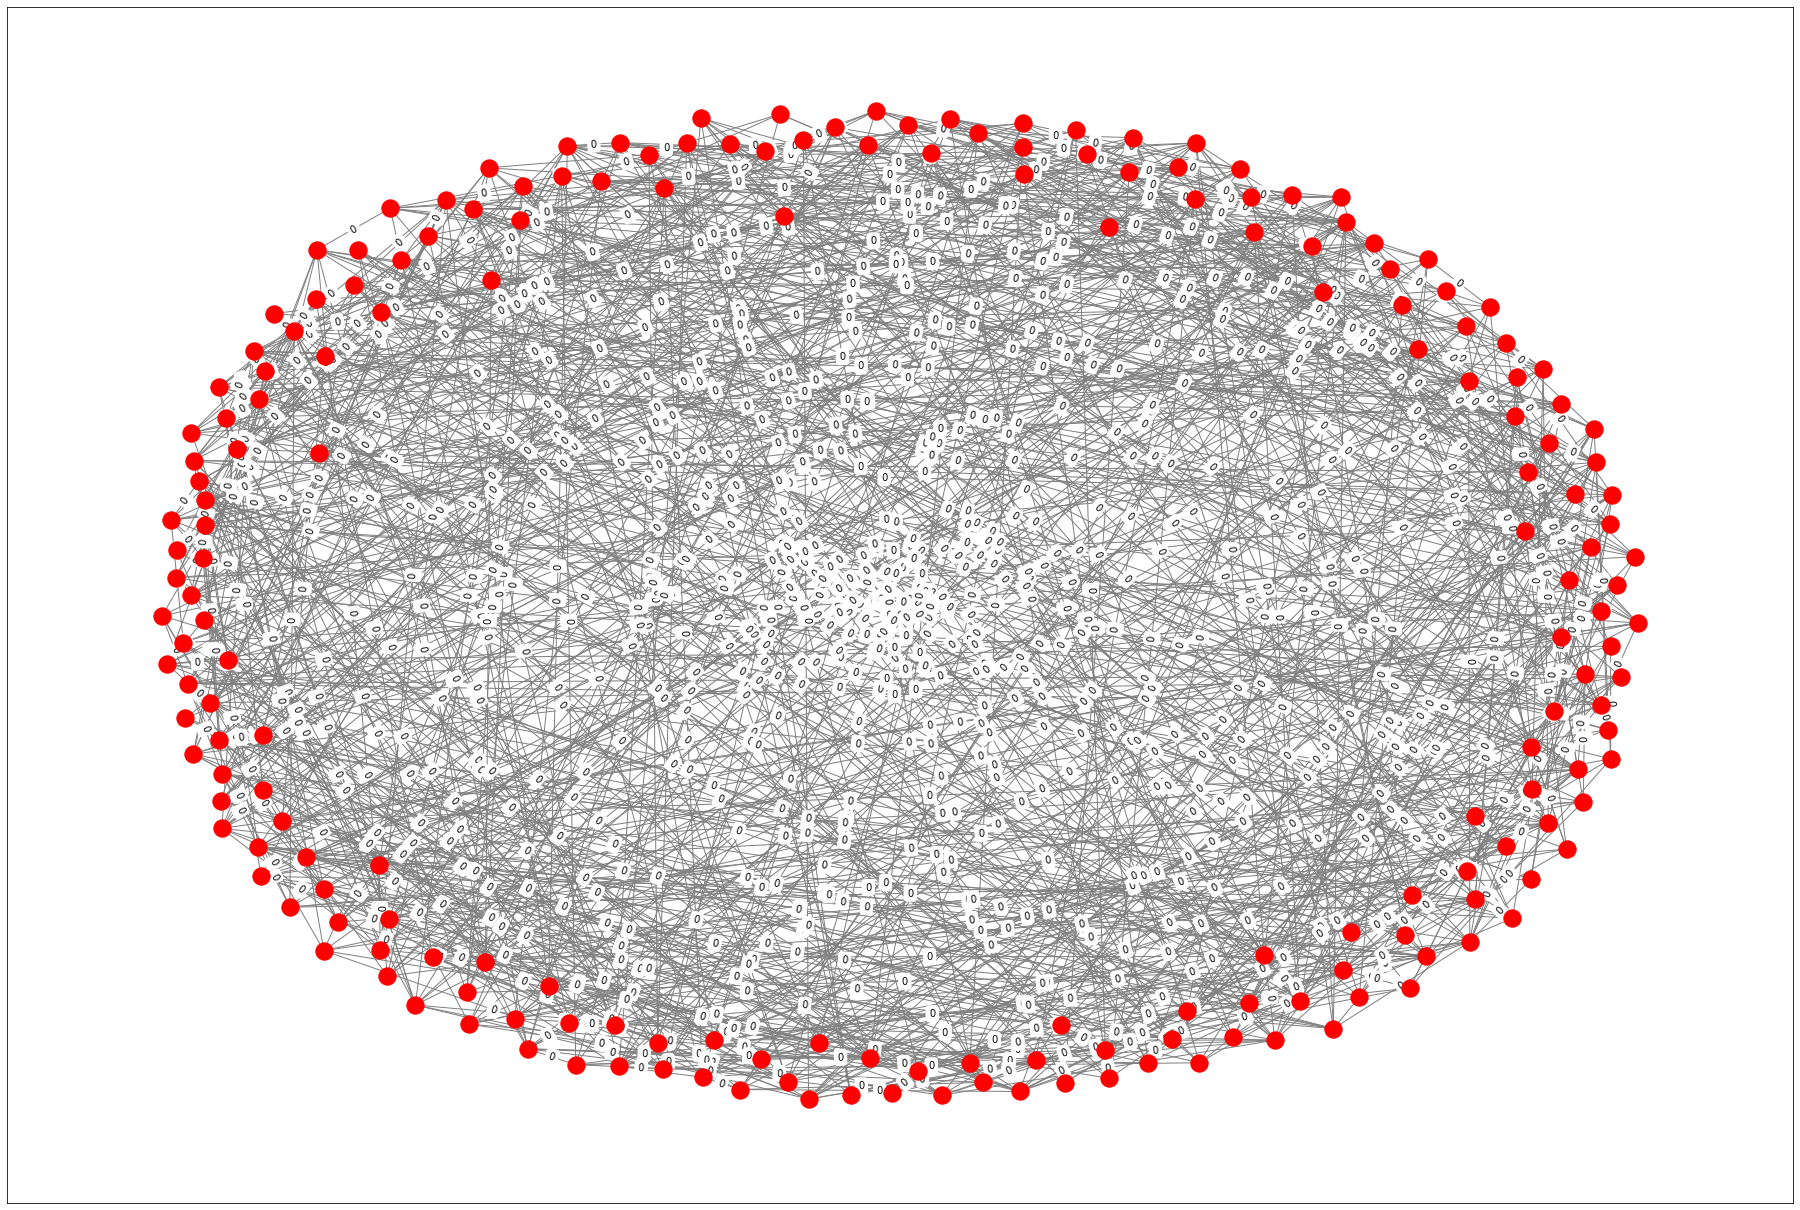

In [40]:
edges = [(i, j) for (i, j) in G.edges()]
nodes = [i for i in G.nodes()]
nodes.sort()
edges.sort()
pos = nx.spring_layout(G, k=0.15)  # spring parameter k
plt.figure(figsize=[32, 22])
nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='r')
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()